# RateAndHalfSat - extended
Nutrient comparisons with edited dataset using surface instead of 2m for depth. (

In [35]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import xarray as xr
from salishsea_tools import tidetools, geo_tools, viz_tools, nc_tools
import pytz
import os
import glob
import matplotlib.cm as cm
%matplotlib inline

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
#load model grid stuff
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
bathy, X, Y = tidetools.get_bathy_data(grid)
mesh = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/mesh_mask201702.nc')

In [3]:
# Load CitSci data and clean it up
nutrients_2015 = pd.read_csv(
    '/ocean/eolson/MEOPAR/obs/PSFCitSci/PSFbottledata2015_CN_edits_EOCor2.csv')
Yinds = np.array([])
Xinds = np.array([])
for n in nutrients_2015.index:
    Yind, Xind = geo_tools.find_closest_model_point(nutrients_2015['lon'][n], 
                                                    nutrients_2015['lat'][n], 
                                                    X, Y, 
                                                    land_mask = bathy.mask)
    Yinds = np.append(Yinds, Yind)
    Xinds = np.append(Xinds, Xind)
nutrients_2015 = nutrients_2015.assign(Yind = Yinds)
nutrients_2015 = nutrients_2015.assign(Xind = Xinds)
nutrients_2015 = nutrients_2015.dropna(subset=['Yind'])
nutrients_2015 = nutrients_2015[~nutrients_2015.flagged]

/data/vdo/MEOPAR/tools/SalishSeaTools/salishsea_tools/geo_tools.py:170: RuntimeWarning: invalid value encountered in greater
  (np.logical_and(model_lons > lon - tols[grid]['tol_lon'],
/data/vdo/MEOPAR/tools/SalishSeaTools/salishsea_tools/geo_tools.py:171: RuntimeWarning: invalid value encountered in less
  model_lons < lon + tols[grid]['tol_lon'])),
/data/vdo/MEOPAR/tools/SalishSeaTools/salishsea_tools/geo_tools.py:172: RuntimeWarning: invalid value encountered in greater
  (np.logical_and(model_lats > lat - tols[grid]['tol_lat'],
/data/vdo/MEOPAR/tools/SalishSeaTools/salishsea_tools/geo_tools.py:173: RuntimeWarning: invalid value encountered in less
  model_lats < lat + tols[grid]['tol_lat']))


In [4]:
nutrients_2015.shape

(890, 13)

In [5]:
model_nutrients = sorted(glob.glob(
    '/data/vdo/MEOPAR/completed-runs/RateAndHalfSat/test*/SalishSea*1d*ptrc*'))

In [6]:
with nc_tools.scDataset(model_nutrients) as f: #takes a while to run, prone to killing kernal
    times = f.variables['time_counter'][:]
    print('times is done')
    model_si = f.variables['silicon'][:, :19, ...]
    print('Si is done')
    model_n023 = f.variables['nitrate'][:, :19, ...]
    print('Nitrate is done')

times is done
Si is done
Nitrate is done


In [7]:
h = nc.Dataset(model_nutrients[0])

In [8]:
# convert into datetime
converted_timesa = nc.num2date(times, h.variables['time_counter'].units)

In [9]:
converted_timesa[0]

datetime.datetime(2015, 2, 1, 12, 0)

In [10]:
converted_timesa[-1]

datetime.datetime(2015, 9, 28, 12, 0)

In [11]:
# mask everything outside of daterange of modelled results 
# apply same mask to everything in CS data
dates = nutrients_2015['date'].values
dates = np.array([pd.to_datetime(dates[n]) for n in range(890)])
dates = np.ma.masked_outside(dates, converted_timesa[0], 
                             converted_timesa[-1])
Yinds = np.ma.masked_array(nutrients_2015['Yind'].values, mask = dates.mask)
Xinds = np.ma.masked_array(nutrients_2015['Xind'].values, mask = dates.mask)
depths = np.ma.masked_array(nutrients_2015['depth'].values, mask = dates.mask)
cs_si = np.ma.masked_array(nutrients_2015['si'].values, mask = dates.mask)
cs_no23 = np.ma.masked_array(nutrients_2015['no23'].values, mask = dates.mask)
stations = np.ma.masked_array(nutrients_2015['station'].values, mask = dates.mask)

In [12]:
np.ma.count(cs_si)

756

In [13]:
list_of_model_si = np.ma.masked_array(np.zeros((890)), mask = True)
list_of_model_ni = np.ma.masked_array(np.zeros((890)), mask = True)
list_of_months = np.ma.masked_array(np.zeros((890)), mask = True)
t = 0
for n in range(890):
    if dates.mask[n] == False:
        Yind = int(Yinds[n])
        Xind = int(Xinds[n])
        date = dates[n]
        if ((depths[n] == 20) and (mesh.variables['tmask'][0,18,Yind,Xind] == 1)):
            index = np.argmin(np.abs(converted_timesa - date))
            s_val = model_si[index, 18,Yind, Xind]
            n_val = model_n023[index, 18, Yind, Xind]
            list_of_model_si.mask[t] = False
            list_of_model_si[t] = s_val
            list_of_model_ni.mask[t] = False
            list_of_model_ni[t] = n_val
            list_of_months.mask = False
            list_of_months[t] = date.month
        if ((depths[n] == 2) and (mesh.variables['tmask'][0,0,Yind,Xind] == 1)):
            index = np.argmin(np.abs(converted_timesa - date))
            s_val = model_si[index, 0,Yind, Xind]
            n_val = model_n023[index, 0, Yind, Xind]
            list_of_model_si.mask[t] = False
            list_of_model_si[t] = s_val
            list_of_model_ni.mask[t] = False
            list_of_model_ni[t] = n_val
            list_of_months.mask = False
            list_of_months[t] = date.month
    t = t + 1

In [14]:
cs_no23.mask = list_of_model_ni.mask
cs_si.mask = list_of_model_si.mask

In [15]:
np.ma.count(cs_no23)

745

In [16]:
np.ma.count(list_of_model_ni)

745

In [28]:
list_of_months.mask = list_of_model_ni.mask

bias =  -0.7214339556378757
RMSE = 7.889166991348282
Willmott = 0.8382500546044427


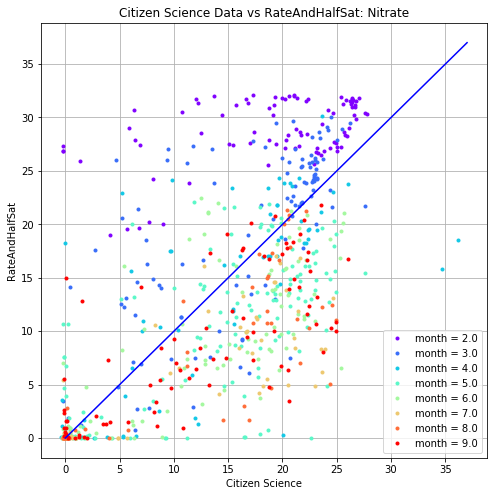

In [37]:
fig, ax = plt.subplots(figsize = (8,8))
colours = cm.rainbow(np.linspace(0,1,8))
for month, colour in zip(np.unique(list_of_months)[:-1], colours):
    ax.plot(cs_no23[list_of_months == month], list_of_model_ni[list_of_months == month], '.', color = colour,
            label = 'month = ' + str(month))
ax.plot(np.arange(0,38), np.arange(0,38), 'b-')
ax.grid('on')
ax.legend()
ax.set_title('Citizen Science Data vs RateAndHalfSat: Nitrate')
ax.set_xlabel('Citizen Science')
ax.set_ylabel('RateAndHalfSat');
print('bias =  ' + str(-np.mean(cs_no23) + np.mean(list_of_model_ni)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_ni - cs_no23)**2) /
                              673)))
xbar = np.mean(cs_no23)
print('Willmott = ' + str(1-(np.sum((list_of_model_ni - cs_no23)**2)  / 
                             np.sum((np.abs(list_of_model_ni - xbar) 
                                     + np.abs(cs_no23 - xbar))**2))))

bias =  -4.635816730844894
RMSE = 15.470561858208042
Willmott = 0.7164088027805159


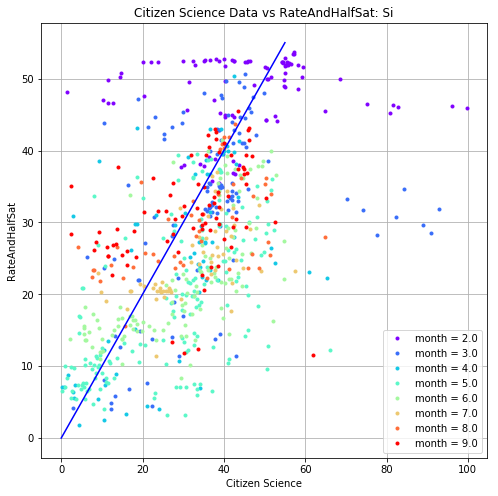

In [38]:
fig, ax = plt.subplots(figsize = (8,8))
colours = cm.rainbow(np.linspace(0,1,8))
for month, colour in zip(np.unique(list_of_months)[:-1], colours):
    ax.plot(cs_si[list_of_months == month], list_of_model_si[list_of_months == month], '.', color = colour,
            label = 'month = ' + str(month))
ax.plot(np.arange(0,56), np.arange(0,56), 'b-')
ax.grid('on')
ax.legend()
ax.set_title('Citizen Science Data vs RateAndHalfSat: Si')
ax.set_xlabel('Citizen Science')
ax.set_ylabel('RateAndHalfSat');
print('bias =  ' + str(-np.mean(cs_si) + np.mean(list_of_model_si)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_si - cs_si)**2) /
                              673)))
xbar = np.mean(cs_si)
print('Willmott = ' + str(1-(np.sum((list_of_model_si - cs_si)**2)  / 
                             np.sum((np.abs(list_of_model_si - xbar) 
                                     + np.abs(cs_si - xbar))**2))))

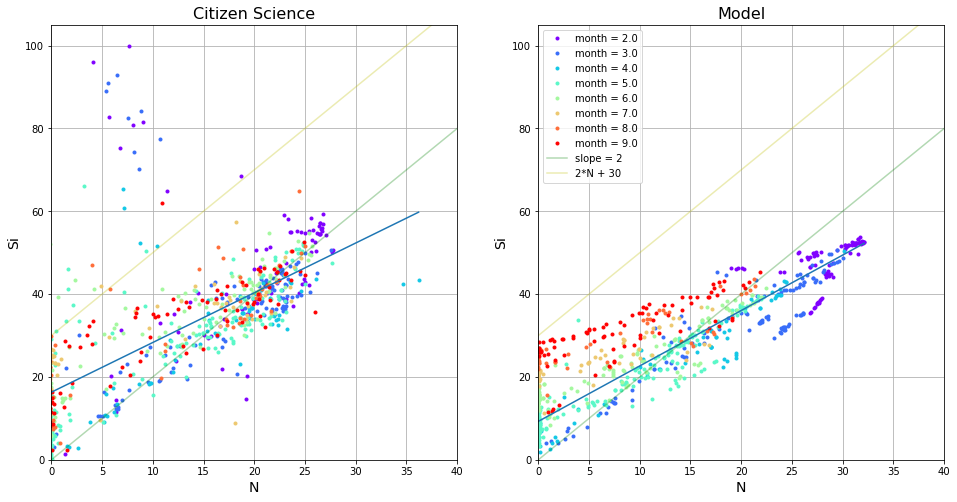

In [39]:
fig, ax = plt.subplots(1,2, figsize = (16,8))
for month, colour in zip(np.unique(list_of_months)[:-1], colours):
    ax[0].plot(cs_no23[list_of_months == month], cs_si[list_of_months == month], '.', color = colour,
            label = 'month = ' + str(month))
ax[0].plot(np.unique(cs_no23), np.poly1d(np.polyfit(cs_no23, cs_si, 1))(np.unique(cs_no23)))
x = np.arange(0,50)
#ax[0].plot(x,x, 'r-', alpha = 0.3)
ax[0].plot(x, 2*x, 'g-', alpha = 0.3)
ax[0].plot(x, 2*x+30, 'y-', alpha = 0.3)
for month, colour in zip(np.unique(list_of_months)[:-1], colours):
    ax[1].plot(list_of_model_ni[list_of_months == month], list_of_model_si[list_of_months == month], '.', 
               color = colour, label = 'month = ' + str(month))
ax[1].plot(np.unique(list_of_model_ni), 
           np.poly1d(np.polyfit(list_of_model_ni, 
                                list_of_model_si, 1))(np.unique(list_of_model_ni)))
x = np.arange(0,53)
#ax[1].plot(x,x, 'r-', alpha = 0.3, label = 'slope = 1')
ax[1].plot(x, 2*x, 'g-', alpha = 0.3, label = 'slope = 2')
ax[1].plot(x, 2*x+30, 'y-', alpha = 0.3, label = '2*N + 30')
ax[0].set_title('Citizen Science', fontsize = 16)
ax[1].set_title('Model', fontsize = 16)
for ax in ax:
    ax.grid('on')
    ax.set_ylabel('Si', fontsize = 14)
    ax.set_xlabel('N', fontsize = 14)
    ax.set_ylim(0,105)
    ax.set_xlim(0,40)
plt.legend();

In [32]:
m1, b1 = np.polyfit(cs_no23, cs_si, 1)
print('CitSci slope = ' + str(m1))
print('CitSci y int = ' + str(b1))
m2, b2 = np.polyfit(list_of_model_ni, list_of_model_si, 1)
print('model slope = ' + str(m2))
print('model y int = ' + str(b2))

CitSci slope = 1.2008970436490647
CitSci y int = 16.313492575414465
model slope = 1.3384318199862666
model y int = 9.2776600814478
